In [1]:
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.api as sm
import numpy as np

# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Forecast energy supply for the next two days 

1. Long-term forecasts not the issue, rather <u> short-term </u>, intra-day supplies
2. What was the supply today and the last few days, controlling for weather, use that as a starting point to forecast the next two days
3. Requires forecasting weather and other short-term effects affecting supply

### Things I tried

1. ARIMA
2. ARIMAX (radiation)
3. Croton
4. Holts-Winter
5. Various decompositions
6. STLForecast

### Need to train-test, no reason yet to compare models

1. Can STLF include ARIMAX (or can it be implemented?)
2. GRU or LSTM would be good to try with exogenous features
3. Help GRU with preprocessing

In [2]:
def datetime_range(start, end, delta):
    '''Need to create time date series'''
    current = start
    while current < end:
        yield current
        current += delta
        
dts = [dt.strftime('%Y-%m-%d %H:%M') for dt in 
       datetime_range(datetime(2020, 4, 1, 0), datetime(2021, 4, 1, 0), 
       timedelta(minutes=15))]

### Read in data

              Total
count  35040.000000
mean      39.316823
std       65.282022
min        0.000000
25%        0.000000
50%        0.362500
75%       60.577500
max      360.375000
Total    float64
dt        object
dtype: object


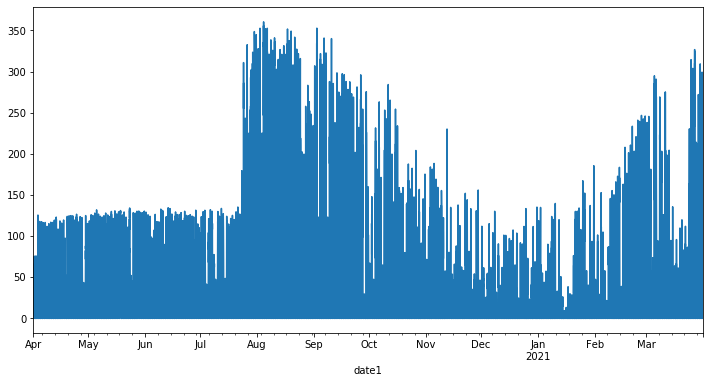

In [3]:
#read in data
dt1 = pd.read_csv('../data/production_raw.csv', dayfirst = True, parse_dates=True, index_col='DateTime')
dt1.rename(columns = {'DateTime': 'Date'}, inplace = True)
dt1['dt'] = dts
dt1['date1'] = pd.to_datetime(dt1['dt'])
dt1.set_index('date1', inplace = True)

dt1['Total'].plot(figsize = (12, 6))

print(dt1.describe())
print(dt1.dtypes)


There appears to be two data generating processes, intersecting around Aug 2020, what happened?

Split the two series in August.

Until there is more data, at least a year of more or less the same data, long-term forecasts won't be helpful.

This is a short-term question, what are the <u> intra-day </u> patterns, like a stock market day trader.

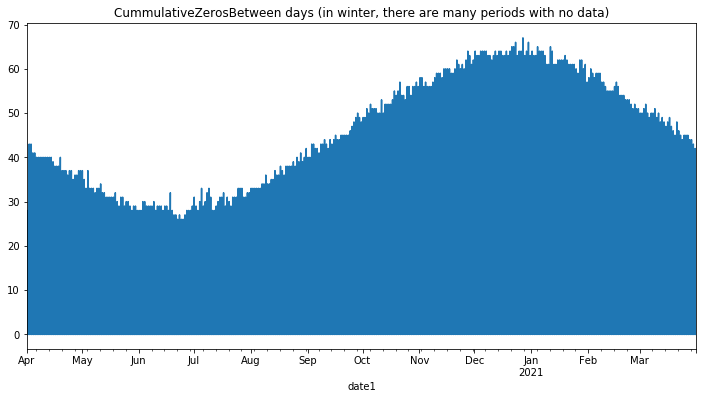

In [4]:
# cmZeros
a = dt1['Total'].shift().eq(0)
b = a.cumsum()
dt1['CmZerosBetween'] = b.sub(b.mask(a).ffill().fillna(0)).astype(int)
dt1['CmZerosBetween'].iloc[0:].plot(figsize = (12, 6), title = "CummulativeZerosBetween days (in winter, there are many periods with no data)")

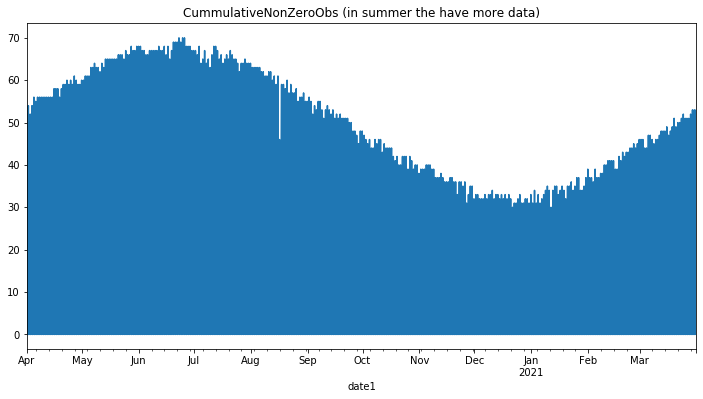

In [5]:
# cmNonZeros
a = dt1['Total'].ne(0)
b = a.cumsum()
dt1['CmNonZeros'] = b.sub(b.mask(a).ffill().fillna(0)).astype(int)
dt1['CmNonZeros'].iloc[0:].plot(figsize = (12, 6), title = 'CummulativeNonZeroObs (in summer the have more data)')

### Import radiation as a possible exogenous variable

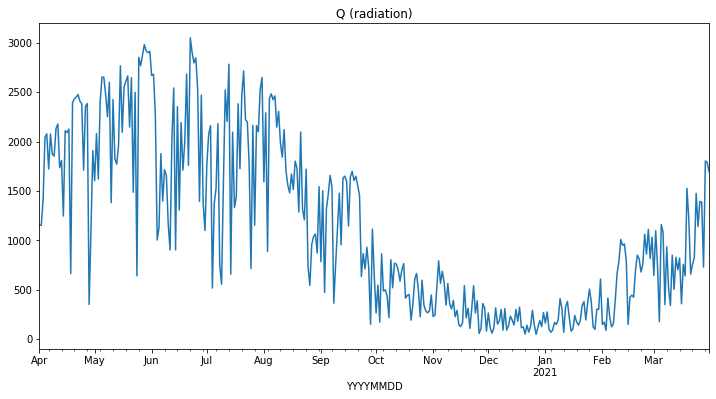

In [6]:
rad1 = pd.read_csv('../data/Radiation.csv', sep = ';')
rad1['YYYYMMDD'] = pd.to_datetime(rad1['YYYYMMDD'],  format='%Y%m%d')
rad1.set_index('YYYYMMDD', inplace = True, drop = True)
rad1.columns = rad1.columns.str.strip()

# select range
start_date = '2020-04-01'
end_date   = '2021-03-31'
rad1['Day'] = rad1.index.floor('D')
rad1.head()
mask = (rad1['Day'] >= start_date) & (rad1['Day'] <= end_date)
rad2 = rad1[mask]
rad2.head()

rad2['Q'].plot(figsize = (12, 6), title = 'Q (radiation)')

### ARIMA

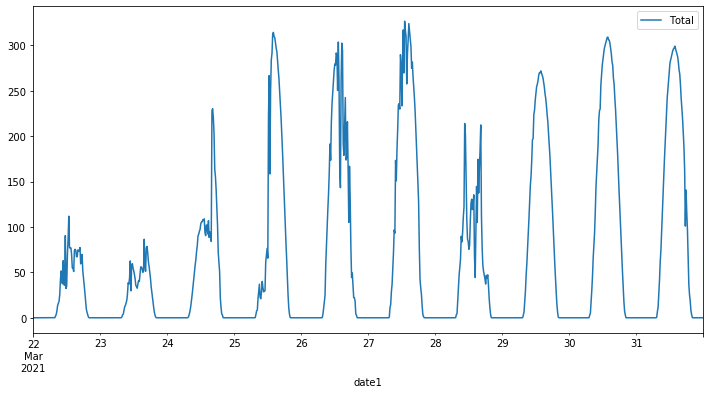

In [215]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

lastNumObs = 960

series = dt1[['Total']].tail(lastNumObs)
series.plot()


/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


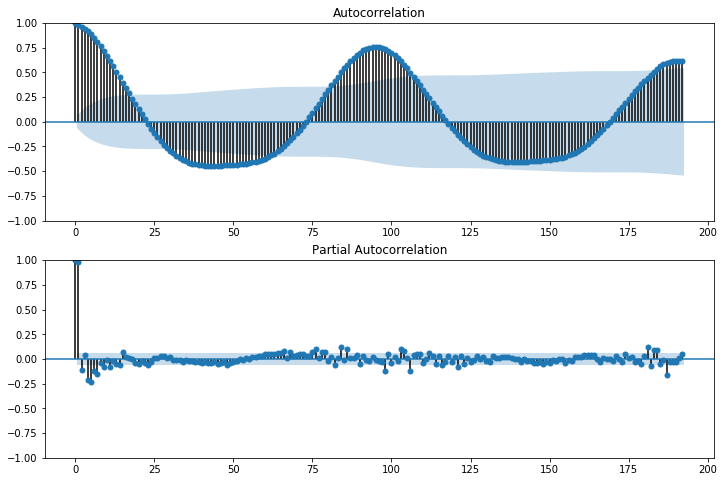

In [216]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags=96*2, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=96*2, ax=ax2)
plt.show()

/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


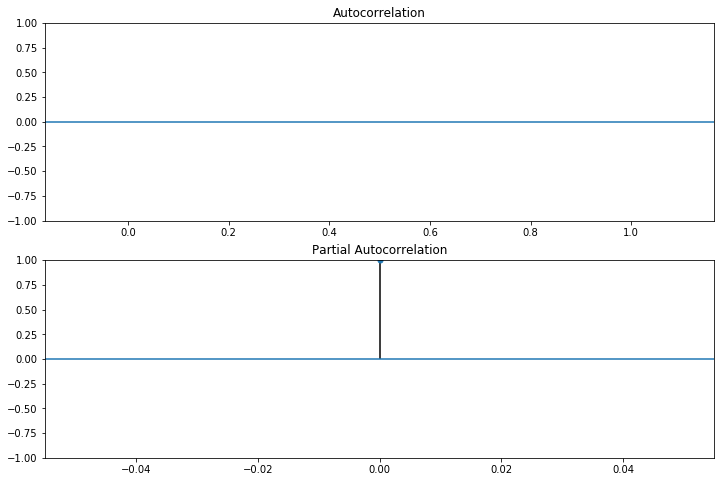

In [218]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series['Total'].diff(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series['Total'].diff(), lags=100, ax=ax2)
plt.show()

<Figure size 864x432 with 0 Axes>

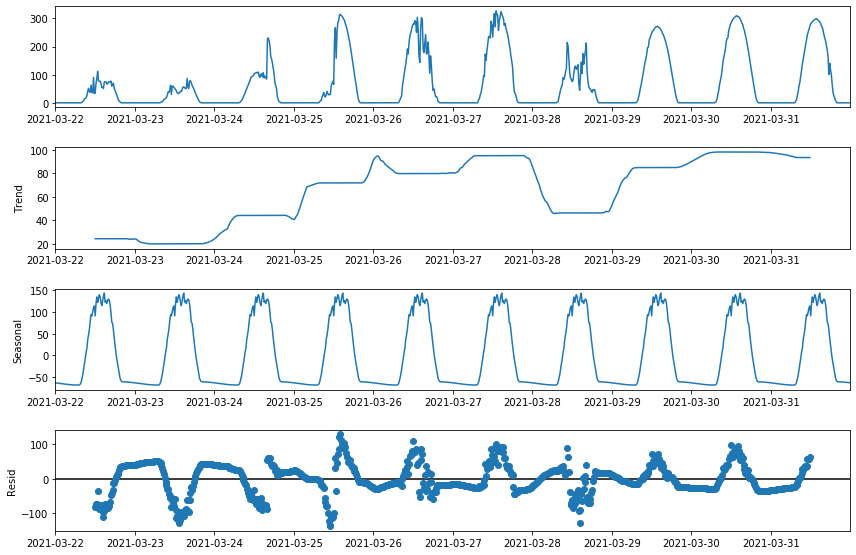

In [199]:
decomposition = seasonal_decompose(series, period=96)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 8)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

# fit model
model = ARIMA(series['Total'], order=(1,1,0), trend='t', seasonal_order = (1,0,0,96))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


predicted=63.940730, expected=44.392500
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=259.721279, expected=261.250000
predicted=-4.226475, expected=0.070000
predicted=0.000000, expected=0.000000
predicted=237.468321, expected=256.252500
predicted=76.345096, expected=65.622500
predicted=-0.000000, expected=0.000000
predicted=144.436187, expected=155.722500
predicted=183.151933, expected=162.707500
Test RMSE: 12.828


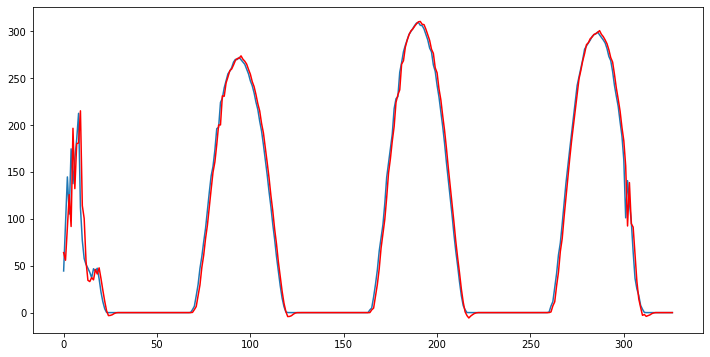

In [230]:
from sklearn.metrics import mean_squared_error
from math import sqrt

data.index = data.index.to_period('15T')
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if t%30 == 0:
        print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [273]:
lastNumObs = 960
subset1 = dt1[-lastNumObs:]
exog1 = np.where(subset1['Total'] != 0, 0, 1)

print(len(subset1))

test_size = 96
train = subset1['Total'][:-test_size]
y = train.values
exogTrain = subset1[['Total']][:-test_size].values
print(len(y))
train_size = len(train)
print(train_size)
test = subset1['Total'][-test_size:]
exogTest = subset1['Total'][-test_size:]
print(len(test))

960
864
864
96


In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Fit your model
model = pm.auto_arima(train, exogenous = exogTrain, seasonal = True, m = 96, stepwise=False, trace=True)

# make your forecasts
forecasts = model.predict(test.shape[0], exogenous = exogTest)  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(12, 6), dpi=80)
x = np.arange(y.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(x[train_size:], forecasts, c='green')
plt.show()

In [ ]:
series['forecast'] = results.predict(start = 900, end= 960, dynamic= True)  
series[['Total', 'forecast']].plot(figsize=(12, 8))

### Holts-Winter

In [72]:
seriesAll = dt1['Total']


(960,)


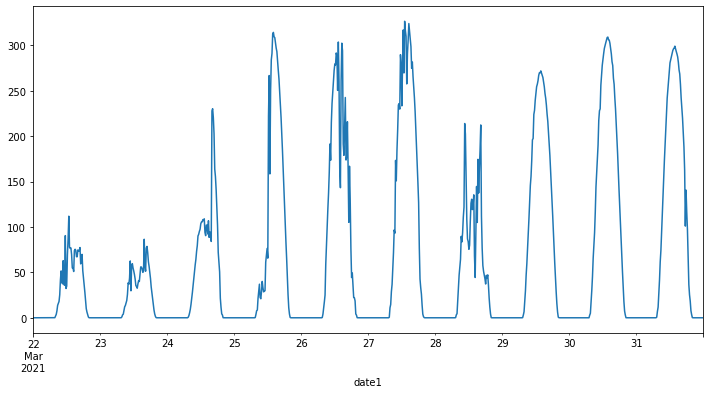

In [93]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
lastNumObs = 96 * 10
data = seriesAll[-lastNumObs:]
print(data.shape)
data.plot(figsize=(12,6))

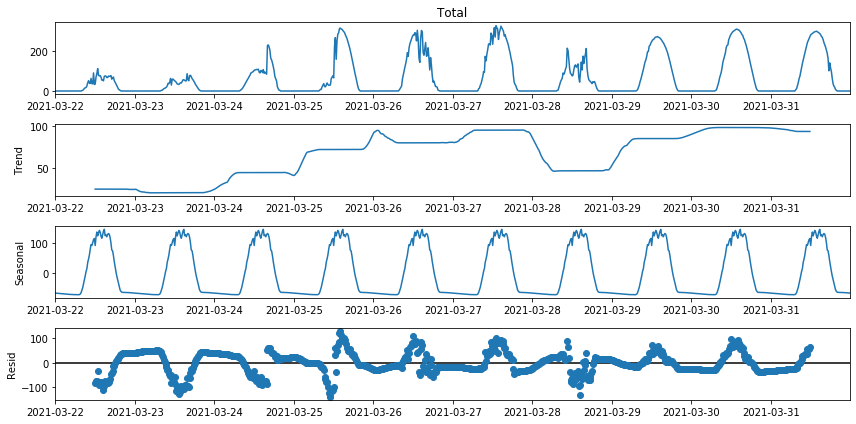

In [24]:
from matplotlib.pyplot import figure
plt.rc("figure", figsize=(12, 6))
plt.rc("font", size=10)

decompose_result = seasonal_decompose(data,model='additive', period = 96)
decompose_result.plot()

m = 96
alpha = 1/(2*m)

In [ ]:
#https://stats.stackexchange.com/questions/127337/explain-the-croston-method-of-r
#https://analyticsindiamag.com/hands-on-guide-to-time-series-analysis-using-simple-exponential-smoothing-in-python/#:~:text=Simple%20Exponential%20Smoothing%20(SES)%20is,statsmodel%20using%20pip%20install%20statsmodel.&text=Simple%20Exponential%20Smoothing%20is%20defined,where%20we%20will%20import%20it.
#https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html
#https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


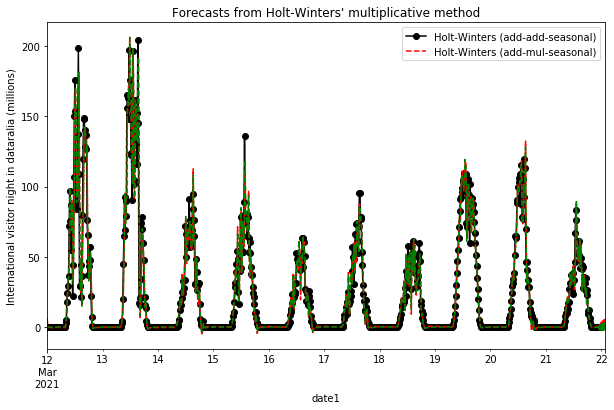

Forecasting (in sample!!!) using Holt-Winters method with both additive and multiplicative seasonality.


,Additive,Additive_Season,Additive Dam
$\alpha$,0.861927,0.946963,0.958936
$\beta$,0.020807,0.005334,0.000097
$\phi$,NaN,0.870074,0.987557
$\gamma$,0.046130,0.007020,NaN
$l_0$,35.224396,28.646437,-0.000100
$b_0$,-0.267690,-0.307849,0.859939
SSE,159658.007166,151906.820321,172645.931792


In [223]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

perds1 = 96

%matplotlib inline

fit1 = ExponentialSmoothing(
    data,
    seasonal_periods=perds1,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
).fit()

fit2 = ExponentialSmoothing(
    data,
    seasonal_periods=perds1,
    trend="add",
    seasonal="add",
    damped_trend=True,
    initialization_method="estimated",
).fit()

fit3 = ExponentialSmoothing(
    data,
    seasonal_periods=perds1,
    trend="add",
    damped_trend=True,
    initialization_method="estimated",
).fit()

results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Additive_Season"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]


ax = data.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in dataralia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()
print(
    "Forecasting (in sample!!!) using Holt-Winters method with both additive and multiplicative seasonality."
)

results

/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/jeff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


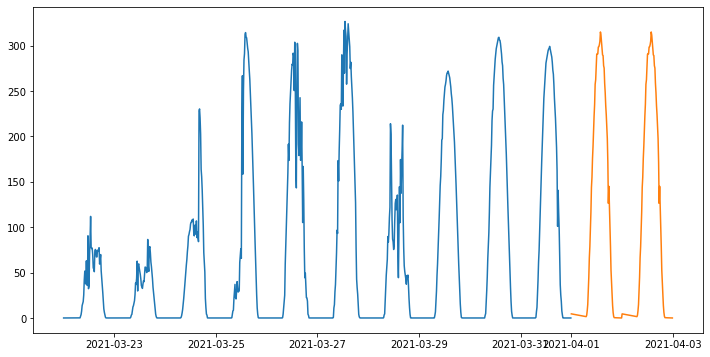

In [228]:
from matplotlib.pyplot import figure
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

plt.rc("figure", figsize=(12, 6))
plt.rc("font", size=10)

#data = dt1.iloc[-lastNumObs * 2:-lastNumObs:]
data = dt1.iloc[-lastNumObs:,]
data = data['Total']

stlf = STLForecast(data, ARIMA, model_kwargs=dict(order=(1, 1, 0)), period=96) #try another trend
stlf_res = stlf.fit()

forecast = stlf_res.forecast(96*2)

plt.plot(data)
plt.plot(forecast)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
trc.values
trc.index

In [ ]:
X = trc.index
#X = np.reshape(X, (len(X), 1))
y = trc.values
X

In [ ]:
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.legend(['data', 'trend'])
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)


dt1['Q'] = np.repeat(rad2.values[:,0], 24 * 4, axis=0)
# Fit and summarize OLS model
dt1.head()
dt1['Q_2'] = dt1['Q'] * dt1['Q']
dt1['Q_3'] = dt1['Q_2'] * dt1['Q']

In [ ]:
exog1 = dt1[['Q', 'Q_2', 'Q_3']].values
exog1 = np.array(exog1, dtype=float)
exog1

In [ ]:
exog1 = sm.add_constant(exog1, prepend=True)

endog1 = dt1['Total'].values

mod = sm.OLS(endog1, exog1)
res = mod.fit()
print(res.summary())

In [225]:
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit

series = dt1['Total'].values
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
y = series.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# plot curve over original data
pyplot.plot(series.values)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
dt2 = dt1[dt1.index >= '2020-08-01']
dtMonth = dt2.groupby(pd.Grouper(freq='D')).sum()
dtMonth['Total'].plot(figsize = (20, 18))

### What are interday patterns, do they change through time?

In [ ]:
dt3 = dt1.drop(columns = ['Date', 'dt', 'CmZerosBetween', 'CmNonZeros'])
dt3.head()
dt3['2020-08-04'].plot(figsize = (20, 13))

In [ ]:
dt3['Day'] = dt3.index.floor('D')

start_date = '2021-01-15'
end_date   = '2021-01-25'

mask = (dt3['Day'] >= start_date) & (dt3['Day'] <= end_date)
dt4 = dt3[mask]

grp1 = dt4.groupby('Day')

for key, dat in grp1:
    dat['Total'].plot(figsize = (20, 8))
    

In [ ]:
start_date = '2020-08-15'
end_date   = '2020-08-25'

mask = (dt3['Day'] >= start_date) & (dt3['Day'] <= end_date)
dt4 = dt3[mask]

grp1 = dt4.groupby('Day')

for key, dat in grp1:
    dat['Total'].plot(figsize = (20, 8))

### Split data

In [ ]:
split = int(len(dt1) * 0.5)
train = dt1.iloc[:split].copy()
dtMonth = train.groupby(pd.Grouper(freq='D')).sum()
dtMonth['Total'].plot(figsize = (20, 18))

In [ ]:
# Add a dummy for data until Aug

In [ ]:
qdata = pd.read_csv('../data/Radiation.csv', sep = ';')
qdata

In [ ]:
pd.to_datetime(qdata['YYYYMMDD'], format = "%Y%m%d").dt.strftime('%Y-%m-%d')